# Module 4.5 - Neural Turing Machines

link to original post: https://blog.wtf.sg/2014/10/27/neural-turing-machines-a-first-look/

link to original paper: https://arxiv.org/pdf/1410.5401.pdf

##### Note: This is not a completed project: the forward pass is implemented compeletly, but the backward pass is still flawed. I will return to this project soon.

## Introduction
Neural Turing Machines were proposed by Google DeepMind in 2014. They speicalize in finding sequential patterns, like RNNs and LSTMs. 

## Theory
### Architecture
NTMs are consisted of two major compoents: a neural network controller and a memory bank. The controller interacts with in the input and produce output like common NNs, but in addition, they also interact with the memeory bank through read/write hands. On the highest level, they look like this: 
![NTM Architecture](https://blog.wtf.sg/wp-content/uploads/2014/10/Screenshot-from-2014-10-30-125035.png)

### Memory Bank 
The memory bank is a matrix sized $(N * M)$. Where M_t is the content being focused on at time step t. 

### Reading
Reading in NTMs are done in a differentiable fashion. In particular, they read blurrily. The read head emit a weight matrix at timestep t, w_t. The weights are normalized so all the elements sum to 1 and ranging (0,1). The *read column vector* (r_t) is the convex combination of w_t and M_t. 

### Writing
The write head emits three vectors: a weight column vector (w_t), an erase row vector (e_t) and an add row vector (a_t). All three are in the range (0,1). 

The writing is consisted of two parts: an erase followed by an add. The steps are as follow: 
1. modify $M_t-1(i)$ by $M_t(i) ← M_t−1(i) * (1 − w_t(i) * e_t)$ where the multiplication is point wise.
2. modify $M_t(i)$ by $M_t(i) ← M_t(i) + w_t(i) * a_t$

The process of multiplying $w_t(i) * a_t$ and $w_t(i) * e_t$ can be intuitivly understood as: find some rows to focus on (where w(i) ~= 1.0) and change the content by $a_t$ and $e_t$. 

Notice, since both multiplication and addition are communitive, it doesn't matter if we have multiply write heads. Doing erasing at the same time nor does it matter if they are adding at the same time. 

### Reading and writing numpy implementation

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline

# memory bank
M = np.ones((3,7))
# add an unique signature to each row
M[0,1] = 3
M[1,4] = 9
M[2,6] = 2

print "Memory bank:"
print M
print ""

# reading
w_r = np.ones((3, 1))
r = np.dot(w_r.T, M)
print "read vector: \n" + repr(r)
print ""

# writing
# erase
e = np.ones((1, 7)) * 0.5
w_w = np.ones((3, 1))
M_tel = np.multiply(M, (1 - np.dot(w_w, e)))
print "Erased memory bank: \n" + repr(M_tel)
print ""

# add
a = np.ones((1, 7))
M = M_tel + np.dot(w_w, a)
print "Added memory bank: \n" + repr(M)
print ""

/Users/macbook/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1120: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Users/macbook/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'ps', u'Qt4Agg', u'GTK', u'GTKAgg', u'nbAgg', u'agg', u'cairo', u'MacOSX', u'GTKCairo', u'Qt5Agg', u'template', u'WXAgg', u'TkAgg', u'GTK3Cairo', u'GTK3Agg', u'svg', u'WebAgg', u'pdf', u'gdk', u'WX']
  (val, error_details, msg))


Memory bank:
[[ 1.  3.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  9.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  2.]]

read vector: 
array([[  3.,   5.,   3.,   3.,  11.,   3.,   4.]])

Erased memory bank: 
array([[ 0.5,  1.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  4.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  1. ]])

Added memory bank: 
array([[ 1.5,  2.5,  1.5,  1.5,  1.5,  1.5,  1.5],
       [ 1.5,  1.5,  1.5,  1.5,  5.5,  1.5,  1.5],
       [ 1.5,  1.5,  1.5,  1.5,  1.5,  1.5,  2. ]])



### Addressing Mechanisms
Addressing help us to produce the weight vectors as described above. I will call those paramters that determine the addressing weightings "configs", and those weightings simply by "weightings".

#### Content-addressing
For each head: 
1. Produce a M-long key vector, $k_t$ and $beta_t$ (key-strength).
2. Calculate the similiarities between the key and the memory matrix.
3. Multiply similiarities with $beta_t$.
3. Normalize the similiarities to produce content weight column vector $w^c_t$.

In [2]:
def sim(a, b):
    # check for same length vectors
    assert len(a.shape) == 1
    assert len(b.shape) == 1
    assert a.shape[0] == b.shape[0]
    # L2
    a_bar = np.linalg.norm(a, ord = 2)
    b_bar = np.linalg.norm(b, ord = 2)
    # for computation stablility
    eps = 1e-10
    return np.dot(a, b) / (eps + a_bar * b_bar)

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)

def softplus(z):
    return np.log(np.exp(z) + 1.0) + 1.0

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [3]:
k = np.ones((7))
k[6] = 3
beta = 10

print "Memory bank:"
print M
print ""
print "Key vector: \n" + repr(k)

Memory bank:
[[ 1.5  2.5  1.5  1.5  1.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  5.5  1.5  1.5]
 [ 1.5  1.5  1.5  1.5  1.5  1.5  2. ]]

Key vector: 
array([ 1.,  1.,  1.,  1.,  1.,  1.,  3.])


In [4]:
w_c = np.zeros((M.shape[0], 1))
for n in range(M.shape[0]):
    w_c[n] = sim(k, M[n, :]) * beta
w_c = softmax(w_c)
print "Content Weight: \n" + repr(w_c)

Content Weight: 
array([[ 0.28527786],
       [ 0.0579956 ],
       [ 0.65672653]])


#### Pre Location-addressing: interpolation gate
Now the network will decide wether to use the last set of weights or use the current content weights, or in other words, wether to location address or content address.

Each head will produce a scalar interpolation gate $g_t$ ranging $(0,1)$. If the gate is close to 1.0, the content vector will be used, otherwise the last weight will be used. However, it is done in a blending fashion. The output is the gated weights: $w^g_t$.

In [5]:
# use the write head as example
g_t = 0.7
w_g = g_t * w_c + (1.0 - g_t) * w_w
print "Gated Weights: \n" + repr(w_g)

Gated Weights: 
array([[ 0.4996945 ],
       [ 0.34059692],
       [ 0.75970857]])


#### Location-addressing: circular convolution
This is perhaps the hardest part of the model. It goes as following: 

For each head:
1. emit shift weighting $s_t$, which defines a normalised distribution over the allowed integer shifts. For example, if shifts between $-1$ and $1$ are allowed, $s_t$ has three elements corresponding to the degree to which shifts of $-1$, $0$ and $1$ are performed.
2. The convoluted weights are calculated (see code).

In [6]:
# shift by each index corrosponds to shifting by 0, 1, and -1
s = np.array([[0.0, 1.0, 0.0]]).T
print "Shift weighting: \n" + repr(s)

Shift weighting: 
array([[ 0.],
       [ 1.],
       [ 0.]])


In [7]:
w_cc = np.zeros_like(w_g)
N = w_g.shape[0]
# circular convolution
for i in range(N):
    for j in range(N):
        w_cc[i] += w_g[j % N] * s[(i - j) % N]
print "Shifted weights: \n" + repr(w_cc)

Shifted weights: 
array([[ 0.75970857],
       [ 0.4996945 ],
       [ 0.34059692]])


#### Sharpening
Finally, in case of leakage, or in other words, when the weights are spread over, we can sharpen them and make them more focused on one location. 

The process is similiar to softmax, but instead of exp function, it uses a scalar emitted by each head $gamma_t$ as exponets, where $gamma_t > 1$

In [8]:
def sharpen(z, gamma):
    return np.power(z, gamma) / np.sum(np.power(z, gamma), axis=0, keepdims=True)

In [9]:
gamma = 5
w = sharpen(w_cc, gamma)
print "Weight: \n" + repr(w)

Weight: 
array([[ 0.87625486],
       [ 0.10787434],
       [ 0.0158708 ]])


### The Three Modes of Addressing
The combined addressing system of weighting interpolation and content and locationbased
addressing can operate in three complementary modes. 
* One, pure content: a weighting can be chosen by the content system without any modification by the location system. 
* Two, random access: a weighting produced by the content addressing system can be chosen and then shifted. This allows the focus to jump to a location next to, but not on, an address accessed by content; in computational terms this allows a head to find a contiguous block of data, then access a particular element within that block. 
* Three, iterative access: weighting from the previous time step can be rotated without any input from the content-based addressing system. This allows the weighting to iterate through a sequence of addresses by advancing the same distance at each time-step.

## Full Implementation
### Memory Matrix
The memory matrix is sized $(N * M)$ and initialized to all 0s.

In [10]:
class MemoryMatrix(object):
    def __init__(self, N, M, random_init = False):
        self.N = N
        self.M = M
        if random_init:
            self.matrix = softmax(np.random.rand(M, N)).T
        else:
            self.matrix = np.zeros((N, M))
            
        self.grad = np.zeros_like(self.matrix)
        self.matrices = []
            
    def archive(self):
        self.matrices.append(np.copy(self.matrix))
        
    def get_last_archive(self):
        return self.matrices[-1]
    
    def pop(self):
        # make sure we have enough time crystals to time travel
        assert len(self.matrices) > 0
        return self.matrices.pop()
    
    def save_gradient(self, grad):
        assert self.grad.shape == self.matrix.shape
        self.grad += grad
        
    def get_gradient(self):
        return self.grad
    
    def clear_grad(self):
        self.grad = np.zeros_like(self.matrix)
        
    def clear_archive(self):
        self.matrices = []

### Heads
Although the paper defined a "head" as the outputs of the controller network, it also seem appropriate if we extent their roles a bit. In particular, I think the job of calculating read vecctors and writing operations should be their role, too.

In [11]:
class Head(object):
    def __init__(self, memory_matrix, W_init):
        self.matrix = memory_matrix.matrix
        self.N = memory_matrix.N
        self.M = memory_matrix.M
        self.W = W_init
        
        ##### for backward prop #####
        self.weightings = []
        self.configs = []
        
    
    def calculate_weights(self, K_hat, S_hat, g_hat, beta_hat, gamma_hat, e = None, a = None):
        ##### calculate and save forward pass varibles here #####
        self.K = K_hat
        self.S = softmax(S_hat)
        self.g = sigmoid(g_hat)
        self.beta = np.exp(beta_hat)
        self.gamma = softplus(gamma_hat)
        # these are only for write vectors
        self.a = a
        self.e = e
        
        ##### do forward calculation here #####
        w_c, sims = self.get_content_weightings()
        
        w_g = self.get_gated_weightings(w_c)
        w_s = self.get_shift_weightings(w_g)
        w = self.get_sharpened_weightings(w_s)
        self.W = w
        
        ##### save weightings and configs for backprop #####
        ## pack ##
        weighting = (w_c, w_g, w_s, sims)
        config = (self.K, self.S, self.g, self.beta, self.gamma)
        ## save ##
        self.weightings.append(weighting)
        self.configs.append(config)
    
    # use weighting gradients to calculate config gradients
    def get_config_grad(self, w_grad, matrix):
        
        ## retrive the variables for back prop ##
        #assert len(self.weightings) > 1
        #assert len(self.configs) > 1
        w_c, w_g, w_s, sims = self.weightings.pop()
        K, S, g, beta, gamma = self.configs.pop()
        
        ##### do backward calculation here #####
        w_s_grad, gamma_grad = self.backprop_sharpened_weightings(w_grad, w_s, gamma)
        w_g_grad, S_grad = self.backprop_shift_weightings(w_s_grad, w_g, S)
        w_c_grad, g_grad = self.backprop_gated_weightings(w_g_grad, w_c, g)
        K_grad, beta_grad = self.backprop_content_weightings(w_c_grad, beta, K, sims, matrix)
        
        # make sure shapes stay consistant
        assert K_grad.shape == K.shape
        assert S_grad.shape == S.shape
        
        return np.hstack([K_grad, S_grad, beta_grad, gamma_grad, g_grad])
            
    ##### helper methods #####
    ## content: forward and backward pair ##
    def get_content_weightings(self):
        
        assert len(self.K.shape) == 1
        assert self.K.shape[0] == self.M
        
        w_c = np.zeros((self.N, 1))
        sims = np.zeros((self.N, 1))
        
        for n in range(N):
            sims[n] = sim(self.K, self.matrix[n, :])
            w_c[n] = sims[n] * self.beta
        w_c = self.softmax(w_c)
        
        return w_c, sims
    
    def backprop_content_weightings(self, outgrad, beta, K, sims, matrix):
        ### calculate the softmax derivative
        exp_term = np.exp(sims * beta)
        sum_term = np.sum(exp_term)
        power_term = exp_term ** 2
        power_sum_term = sum_term ** 2
        softmax_deriv = (exp_term * sum_term - power_term) / power_sum_term
        
        beta_grad = np.sum(np.multiply(outgrad, np.multiply(sims, softmax_deriv)))
        sims_grad = np.multiply(outgrad, beta * softmax_deriv)
        
        ##### WARNING: I'm not going to calculate the matrix gradient
        ##### WARNING: I'm going to use the lowest error to determine the error on the key
        K_grad = K - matrix[np.argmin(sims_grad)]
        
        return K_grad, beta_grad
    
    ## gate: forward and backward pair ##
    def get_gated_weightings(self, w_c):
        
        assert self.W.shape == w_c.shape
        
        w_g = self.g * w_c + (1.0 - self.g) * self.W
        return w_g
    
    def backprop_gated_weightings(self, outgrad, w_c, g):
        ##### WARNING: I'm not going to propagate error to the past weightings #####
        ## I think some information will be lost here, but not ALL will be lost. 
        ## As long as the error on the gate config is passed back, I believe the model
        ## will eventually converge. 
        w_c_grad = outgrad / g
        g_grad = np.sum(outgrad / w_c)
        
        return w_c_grad, g_grad
    
    ## shift: forward and backward pair ##
    def get_shift_weightings(self, w_g):
        w_s = np.zeros_like(w_g)
        # circular convolution
        for i in range(self.N):
            for j in range(self.N):
                w_s[i] += w_g[j % self.N] * self.S[(i - j) % self.N]
        return w_s

    def backprop_shift_weightings(self, outgrad, w_g, S):
        ### since shift configs are shifted at each row calculation
        ##  let's shift them first
        S_shifted = np.zeros((S.shape[0], S.shape[0]))
        for i in range(S.shape[0]):
            S_shifted[i] = np.roll(S, i)
        w_g_grad = np.dot(S_shifted.T, outgrad)
        
        S_shifted_grad = np.dot(outgrad, w_g.T)
        ## now roll the grads back to original shape
        for i in range(S.shape[0]):
            S_shifted[i] = np.roll(S_shifted[i], -i)
            
        S_grad = np.sum(S_shifted, axis = 0)
        
        return w_g_grad, S_grad
        
    ## sharpen: forward and backward pair ##
    def get_sharpened_weightings(self, w_s):
        w = self.sharpen(w_s, self.gamma)
        return w
    
    def backprop_sharpened_weightings(self, outgrad, w_s, gamma):
        ##### sharpen function's derivative terms #####
        power_term = np.power(w_s, gamma)
        power_sum_term = np.sum(power_term, axis=0, keepdims=True)
        log_term = np.log(w_s)
        log_sum_term = np.sum(log_term, axis=0, keepdims=True)
        log_diff_term = log_term - log_sum_term
        
        ### getting the backprop grad
        w_s_deriv = (power_sum_term - power_term) / (power_sum_term ** 2)
        # chain rule
        w_s_grad = np.multiply(outgrad, w_s_deriv)

        ### getting the gamma grad
        beta_grad = np.sum(np.multiply(outgrad, np.multiply(power_term, log_diff_term) / power_sum_term))
        
        return w_s_grad, beta_grad
    
    
    ##### utils #####
    def sim(self, a, b):
        # check for same length vectors
        assert len(a.shape) == 1
        assert len(b.shape) == 1
        assert a.shape[0] == b.shape[0]
        # L2
        a_bar = np.linalg.norm(a, ord = 2)
        b_bar = np.linalg.norm(b, ord = 2)
        # for computation stablility
        eps = 1e-10
        return np.dot(a, b) / (0.0 + a_bar * b_bar)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)
    
    def sharpen(self, z, gamma):
        return np.power(z, gamma) / np.sum(np.power(z, gamma), axis=0, keepdims=True)

### Read Heads and Write Heads
We will define read heads by inherenting the Head class. We will extend a interact_with_matrix method to return the read vector (read heads) or to manipulate matrix (write heads).

In [12]:
class ReadHead(Head):
    def read(self):
        r = np.dot(self.W.T, self.matrix)
        # always make sure we get all the read outputs
        assert r.shape[0] == 1
        return r[0]
    
    # returns matrix gradients & head weighting gradients
    # matrix_h is the historical version of the matrix
    def backward(self, outgrad, matrix_h):
        #assert len(outgrad.shape) == 1
        #assert outgrad.shape[0] == self.M
        assert outgrad.shape[1] == self.M
        
        # matrix grad is for write head to bptt
        matrix_grad = np.dot(self.W, outgrad)
        # w_grad is for read head config bptt
        w_grad = np.dot(matrix_h, outgrad.T)
        
        return matrix_grad, w_grad

In [13]:
class WriteHead(Head):
    def erase(self):    
        assert len(self.e.shape) == 2
        assert self.e.shape[0] == 1
        assert self.e.shape[1] == self.M
        # modify the matrix, not change reference
        self.matrix[:] = np.multiply(self.matrix, (1 - np.dot(self.W, self.e)))[:]
        
    def add(self):
        assert len(self.a.shape) == 2
        assert self.a.shape[0] == 1
        assert self.a.shape[1] == self.M
        # modify the matrix, not change reference
        self.matrix[:] = (self.matrix + np.dot(self.W, self.a))[:]
        
    # takes the matrix grad after add, and matrix value before erase
    # returns write weighting gradients, add vector gradients, and erase gradients
    def backward(self, matrix_grad, matrix_h_e):
        eps = 0.0001
        a_grad = np.dot(self.W.T, matrix_grad)
        # w_grad at add time
        w_grad = np.dot(matrix_grad, self.a.T)
        # matrix grad at add time is the same as matrix grad at erase time
        # for erase grad, we need to rearrange the terms in erase equations first
        matrix_grad /= - matrix_h_e + eps
        ### What if it's the first iteration? Hence the matrix is all zeros? 
        ### That case we would encounter a division by 0 error
        e_grad = np.dot(self.W.T, matrix_grad)
        # add the w_grad at erase time on top of w_grad at add time
        w_grad += np.dot(matrix_grad, self.e.T)
        
        return w_grad, a_grad, e_grad

### Controller
We will calculate controller sizes using the number of heads, input size, output size, and memory matrix sizes. 

In [14]:
# gradient clipping
def clip(grad, min_g, max_g):
    grad = np.minimum(grad, max_g)
    grad = np.maximum(grad, min_g)
    return grad

def assert_clipped(grad, min_g, max_g):
    assert (grad >= min_g).all()
    assert (grad <= max_g).all()

In [15]:
# a simple feedforward layer
class Linear(object):
    def __init__(self, W):
        self.W = W
        self.X = []
        self.grad = np.zeros_like(self.W)
        
    def update(self, lr):
        self.checkRep()
        self.W -= self.grad * lr
        self.grad = np.zeros_like(self.W)
        
    def forward(self, X):
        # save for backprop thru time
        self.X.append(X)
        return np.dot(self.W.T, X)
    
    def backward(self, outgrad):
        outgrad = clip(outgrad, -10, 10)
        assert_clipped(outgrad, -10, 10)
        # accumulate gradient
        assert len(self.X) > 0

        self.grad += np.dot(np.array([self.X.pop()]).T, np.array([outgrad]))
        
        return np.dot(self.W, outgrad)
    
    def checkRep(self):
        assert self.grad.shape == self.W.shape

In [16]:
class Sigmoid(object):
    def __init__(self):
        self.Y = []
        
    def forward(self, X):
        # save for bptt
        self.Y.append(sigmoid(X))
        return self.Y[-1]
    
    def backward(self, outgrad):
        # you can go back in time NO LONGERRRR!! (unfortunatly)
        assert len(self.Y) > 0
        
        Y = self.Y.pop()
        return Y * (1 - Y) * outgrad
    
    def update(self, lr):
        pass

In [17]:
class Controller(object):
    def __init__(self, graph):
        self.graph = graph
        
    def forward(self, X):
        z = X
        for n in self.graph: 
            z = n.forward(z)
        return z
    
    def backward(self, outgrad):
        grad = outgrad
        for n in reversed(self.graph):
            grad = n.backward(grad)
        return grad
    
    def update(self, lr):
        for n in self.graph:
            n.update(lr)

### NTM

In [97]:
class NeuralTuringMachine(object):
    def __init__(self, memory_matrix, controller, nb_of_w_heads, nb_of_r_heads):
        self.N = memory_matrix.N
        self.M = memory_matrix.M
        # componets
        self.controller = controller
        self.matrix = memory_matrix.matrix
        self.w_heads = []
        self.r_heads = []
        self.memory_matrix = memory_matrix
        memory_matrix.archive()
        
        # mount the heads
        for i in range(nb_of_w_heads):
            self.w_heads.append(WriteHead(memory_matrix, np.random.uniform(0, 1, (self.N, 1))))
        for i in range(nb_of_r_heads):
            self.r_heads.append(ReadHead(memory_matrix, np.random.uniform(0, 1, (self.N, 1))))

        self.r = np.zeros((self.M * nb_of_r_heads))
        
    def step_forward(self, X):
        # for convience's sake
        N = self.N
        M = self.M
        
        # input + read vector
        z = np.zeros((X.shape[0] + self.r.shape[0]))
        z[:X.shape[0]] = X
        z[X.shape[0]:] = self.r
        
        # forward through the controller
        z = self.controller.forward(z)
        
        # write weights first
        for h in self.w_heads:
            z_split = np.split(z, [M, M * 2, M * 3, M * 3 + N, M * 3 + N + 1, M * 3 + N + 2, M * 3 + N + 3])
            
            e = np.array([z_split[0]])
            a = np.array([z_split[1]])
            
            K = z_split[2]
            S = z_split[3]
            beta = z_split[4]
            gamma = z_split[5]
            g = z_split[6]
            z = z_split[7]
            
            h.calculate_weights(K, S, g, beta, gamma, e, a)
            
            
        # read weights second
        for h in self.r_heads:
            z_split = np.split(z, [M, M + N, M + N + 1, M + N + 2, M + N + 3])
            
            K = z_split[0]
            S = z_split[1]
            beta = z_split[2]
            gamma = z_split[3]
            g = z_split[4]
            z = z_split[5]
            
            h.calculate_weights(K, S, g, beta, gamma)
            
            
        # write to matrix
        for h in self.w_heads:
            h.erase()
            h.add()
            
        # read matrix & update read vector
        self.r = np.array([])
        for h in self.r_heads:
            self.r = np.hstack([self.r, h.read()])
                                
        ##### save the matrix right now 
        ##   (since we need to back prop thru time later)
        self.memory_matrix.archive()
        
        return z
    
    # backprop one timestep
    # return the config gradients, aka the grads for one portion of the output of ontroller
    def step_backward(self, outgrad):
        grad = self.controller.backward(outgrad)
        # read weighting grads
        grad = grad[:self.r.shape[0]]
        
        config_grad = np.array([])
        # we don't need this version of matrix anymore
        matrix_h = self.memory_matrix.pop()
        # we still need this version of matrix because 
        #   matrix before erase is the matrix after last read
        #   which is what we need for for the next 
        matrix_h_e = self.memory_matrix.get_last_archive()
        
        # backprop read heads first
        for h in self.r_heads:
            grad_split = np.split(grad, [self.M])
            
            #### split for each head
            h_grad = grad_split[0]
            grad = grad_split[1]
            
            h_grad = np.array([h_grad])
            
            matrix_grad, w_grad = h.backward(h_grad, matrix_h)
            # put this in the controller output style
            config_grad = np.hstack([config_grad, h.get_config_grad(w_grad, matrix_h_e)])
            # save it for later use
            self.memory_matrix.save_gradient(matrix_grad)
        
        # back prop write heads
        for h in reversed(self.w_heads):
            w_grad, a_grad, e_grad = h.backward(self.memory_matrix.get_gradient(), matrix_h_e)
            
            # append in reverse order so it matched how input came in
            config_grad = np.hstack([e_grad[0], a_grad[0], h.get_config_grad(w_grad, matrix_h_e), config_grad])
        
        # clear grad for next run
        self.memory_matrix.clear_grad()
        
        return config_grad
    
    def update(self, lr):
        self.controller.update(lr)

## Simple Incremental Number Task - PASS
We task the model by giving it an input from 0 - 5 encoded in one hot vector and ask what's the next increment.

This can be achieved by simple feedforward NNs.

In [292]:
m = MemoryMatrix(7, 6, random_init = True)
graph = [Linear(np.random.uniform(-1, 1, (6 + 6, 50))), Sigmoid(), Linear(np.random.uniform(-1, 1, (50, 70))), Sigmoid(), Linear(np.random.uniform(-1, 1, (70, 28*1 + 16*1 + 6))), Sigmoid()]
con = Controller(graph)
nb_of_w_heads = 1
nb_of_r_heads = 1
ntm = NeuralTuringMachine(m, con, nb_of_w_heads, nb_of_r_heads)

In [293]:
costs = []
for _ in tqdm(range(100)):
    Y = []
    for i in range(12):
        a = np.zeros((6))
        a[i % 6] = 1
        Y.append(ntm.step_forward(a))

    config_grad = np.zeros(28*1 + 16*1)
    for i in reversed(range(12)):
        T = np.zeros((6))
        T[(i + 1)% 6] = 1
        
        cost = Y[i] - T
        costs.append(np.sum(abs(cost)))
        grad = np.hstack([config_grad, cost])
        config_grad = ntm.step_backward(grad)

    ntm.update(0.1)

100%|██████████| 100/100 [00:02<00:00, 36.50it/s]


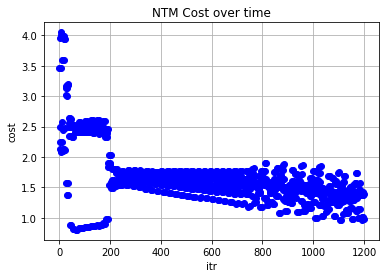

In [294]:
# plot learning curve
plt.plot(costs, 'bo')
plt.xlabel('itr')
plt.ylabel('cost')
plt.title('NTM Cost over time')
plt.grid()
plt.show()

In [295]:
for i in range(6):
    test = np.zeros((6))
    test[i] = 1
    print np.argmax(ntm.step_forward(test))

1
2
3
4
5
0


## Constant Input Incremental Number Task - NO PASS
This task is esstentially the same as above, but with a twist: the input is alwsys constant. So we are trying to see if the model can establish temporal dependency.

This CANNOT be achieved by simple feedforward NNs.

In [273]:
m = MemoryMatrix(7, 6, random_init = True)
graph = [Linear(np.random.uniform(-1, 1, (6 + 6, 50))), Sigmoid(), Linear(np.random.uniform(-1, 1, (50, 70))), Sigmoid(), Linear(np.random.uniform(-1, 1, (70, 28*1 + 16*1 + 6))), Sigmoid()]
con = Controller(graph)
nb_of_w_heads = 1
nb_of_r_heads = 1
ntm = NeuralTuringMachine(m, con, nb_of_w_heads, nb_of_r_heads)

In [274]:
costs = []
for _ in tqdm(range(10000)):
    Y = []
    for i in range(6):
        a = np.zeros((6))
        #a[i % 6] = 1
        Y.append(ntm.step_forward(a))

    config_grad = np.zeros(28*1 + 16*1)
    for i in reversed(range(6)):
        T = np.zeros((6))
        T[(i + 1)% 6] = 1
        
        cost = Y[i] - T
        costs.append(np.sum(abs(cost)))
        grad = np.hstack([config_grad, cost])
        config_grad = ntm.step_backward(grad)
        
    ntm.update(0.05)

100%|██████████| 10000/10000 [02:25<00:00, 68.66it/s]


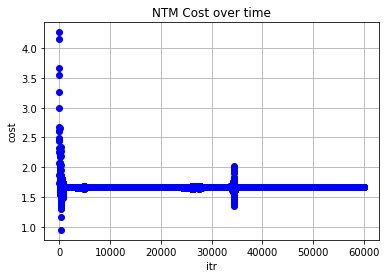

In [275]:
# plot learning curve
plt.plot(costs, 'bo')
plt.xlabel('itr')
plt.ylabel('cost')
plt.title('NTM Cost over time')
plt.grid()
plt.show()

In [279]:
for i in range(6):
    test = np.zeros((6))
    #test[(i) % 6] = 1
    print np.argmax(ntm.step_forward(test))

0
0
0
0
0
0


## Temporal AND Task - NO PASS
We task the model to perform ADD operation by giving it the operands sperately. This task helps us to whether evaluate can save data into its matrix and read it later. 

In [264]:
N = 2
M = 1
I = 1
O = 1

m = MemoryMatrix(2, 1, random_init = True)
graph = [Linear(np.random.uniform(-1, 1, (M + I, 10))), Sigmoid(), Linear(np.random.uniform(-1, 1, (10, 10))), Sigmoid(), Linear(np.random.uniform(-1, 1, (10, (3 * M + N + 3)*1 + (M + N + 3)*1 + O))), Sigmoid()]
con = Controller(graph)
nb_of_w_heads = 1
nb_of_r_heads = 1
ntm = NeuralTuringMachine(m, con, nb_of_w_heads, nb_of_r_heads)

In [269]:
costs = []
config_grad = np.zeros((3 * M + N + 3)*1 + (M + N + 3)*1)
for _ in tqdm(range(10000)):
    
    for _ in range(10):
        a = np.random.randint(0, 2, (1))
        b = np.random.randint(0, 2, (1))
        if a[0] == 1 and b[0] == 1:
            T = np.array([1])
        else:
            T = np.array([0])

        ntm.step_forward(a)
        Y = ntm.step_forward(b)

        cost = Y - T
        costs.append(np.sum(abs(cost)))

        grad = np.hstack([config_grad, cost])
        config_grad = ntm.step_backward(grad)

        ntm.update(0.1)

100%|██████████| 10000/10000 [03:12<00:00, 52.01it/s]


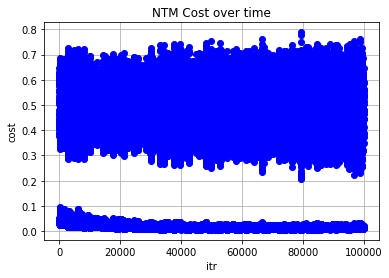

In [270]:
# plot learning curve
plt.plot(costs, 'bo')
plt.xlabel('itr')
plt.ylabel('cost')
plt.title('NTM Cost over time')
plt.grid()
plt.show()

In [271]:
a = np.array([0])
b = np.array([1])
#test[(i) % 6] = 1
ntm.step_forward(a)
print ntm.step_forward(b)

a = np.array([1])
b = np.array([1])
#test[(i) % 6] = 1
ntm.step_forward(a)
print ntm.step_forward(b)

[ 0.63446824]
[ 0.6616905]
